# 💼 Cryptocurrency Portfolio Optimization: Markowitz, Risk Parity & More

## Advanced Portfolio Construction with Multiple Optimization Strategies

This notebook implements comprehensive portfolio optimization methods for cryptocurrency investments:

- **📊 Mean-Variance Optimization** - Markowitz portfolio theory for optimal risk-return trade-offs
- **⚖️ Risk Parity** - Equal risk contribution portfolio
- **📉 Minimum Variance Portfolio** - Lowest risk portfolio construction
- **📈 Maximum Sharpe Ratio** - Optimal risk-adjusted returns
- **📊 Efficient Frontier** - Visualization of optimal portfolios
- **🔄 Portfolio Backtesting** - Historical performance evaluation
- **⚙️ Rebalancing Strategies** - Dynamic portfolio management

### Key Features:
✅ **Auto Library Installation** - Automatically installs missing dependencies  
✅ **Kaggle Compatible** - Works seamlessly on Kaggle and local environments  
✅ **Multiple Strategies** - 4 different optimization approaches  
✅ **Backtesting** - Historical performance analysis  
✅ **Visualizations** - Efficient frontier, portfolio weights, performance charts  

### 📌 **Kaggle Compatible**
This notebook automatically detects if it's running on Kaggle and uses the appropriate dataset path.

---

**Keywords:** Portfolio Optimization, Markowitz, Risk Parity, Sharpe Ratio, Efficient Frontier, Cryptocurrency, Asset Allocation, Risk Management, Backtesting


In [1]:
# Check and Install Required Libraries
import subprocess
import sys
import importlib

def check_and_install(package_name, import_name=None):
    """Check if a package is installed, if not, install it."""
    if import_name is None:
        import_name = package_name
    
    try:
        importlib.import_module(import_name)
        return True
    except ImportError:
        print(f"⚠️ {package_name} not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "--quiet"])
            print(f"✅ {package_name} installed successfully!")
            return True
        except Exception as e:
            print(f"❌ Failed to install {package_name}: {str(e)}")
            return False

# Required packages
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'scipy': 'scipy',
    'scikit-learn': 'sklearn',
}

print("="*60)
print("CHECKING AND INSTALLING REQUIRED LIBRARIES")
print("="*60)

# Check and install packages
installed_packages = {}
for pip_name, import_name in required_packages.items():
    installed = check_and_install(pip_name, import_name)
    installed_packages[import_name] = installed

print("\n" + "="*60)
print("LIBRARY STATUS")
print("="*60)

# Now import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy.linalg import inv, pinv
import math

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

print("\n" + "="*60)
print("✅ LIBRARY CHECK COMPLETE")
print("="*60)


CHECKING AND INSTALLING REQUIRED LIBRARIES

LIBRARY STATUS
✅ Libraries imported successfully!
NumPy version: 2.0.2
Pandas version: 2.3.3

✅ LIBRARY CHECK COMPLETE


## 1. Data Loading and Preparation


In [2]:
# Define paths - Auto-detect Kaggle environment
if os.path.exists('/kaggle/input'):
    kaggle_base = Path('/kaggle/input/top-50-cryptocurrency-dataset')
    if kaggle_base.exists():
        csv_files_direct = list(kaggle_base.glob('*.csv'))
        if len(csv_files_direct) > 0:
            base_path = kaggle_base
            print("🔵 Running on Kaggle - CSV files found directly in dataset folder")
        else:
            dataset_subfolder = kaggle_base / 'Dataset'
            if dataset_subfolder.exists():
                base_path = dataset_subfolder
                print("🔵 Running on Kaggle - CSV files found in Dataset subfolder")
            else:
                base_path = kaggle_base
                print("🔵 Running on Kaggle - Using base dataset path")
    else:
        kaggle_input = Path('/kaggle/input')
        available_datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
        if available_datasets:
            base_path = available_datasets[0]
            print(f"🔵 Using: {base_path}")
        else:
            base_path = kaggle_base
else:
    base_path = Path('../Dataset')
    print("🟢 Running locally - Using local dataset path")

# Function to load cryptocurrency data
def load_crypto_data(file_path):
    """Load cryptocurrency CSV file and handle the header issue."""
    try:
        df = pd.read_csv(file_path, skiprows=[1])
        crypto_name = file_path.stem.replace('_', ' ').title()
        df['Date'] = pd.to_datetime(df['Date'])
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.sort_values('Date').reset_index(drop=True)
        df['Cryptocurrency'] = crypto_name
        return df, crypto_name
    except Exception as e:
        print(f"Error loading {file_path.name}: {str(e)}")
        return None, None

# Load all cryptocurrency data
csv_files = list(base_path.glob('*.csv'))
if len(csv_files) == 0:
    csv_files = list(base_path.rglob('*.csv'))

crypto_data = {}
for file_path in csv_files:
    df, name = load_crypto_data(file_path)
    if df is not None and len(df) > 200:  # Need sufficient data for portfolio analysis
        crypto_data[name] = df

print(f"\n✅ Loaded {len(crypto_data)} cryptocurrencies with sufficient data")
print(f"Available cryptocurrencies: {sorted(list(crypto_data.keys())[:10])}...")


🟢 Running locally - Using local dataset path

✅ Loaded 49 cryptocurrencies with sufficient data
Available cryptocurrencies: ['Chainlink', 'Flow', 'Hedera', 'Immutable', 'Kaspa', 'Near', 'Render', 'Sui', 'The Graph', 'Xrp']...


In [3]:
# Select cryptocurrencies for portfolio construction
# Using top cryptocurrencies with good data coverage
selected_cryptos = ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Binance Coin', 
                    'Xrp', 'Polygon', 'Avalanche', 'Polkadot', 'Chainlink']

# Filter to available cryptos
available_selected = [c for c in selected_cryptos if c in crypto_data]
if len(available_selected) < 3:
    # Use first available cryptos if selected ones aren't available
    available_selected = list(crypto_data.keys())[:min(10, len(crypto_data))]

print(f"Selected cryptocurrencies for portfolio: {available_selected}")

# Prepare price data for portfolio analysis
portfolio_data = {}
for crypto in available_selected:
    df = crypto_data[crypto].copy()
    df = df[['Date', 'Close']].copy()
    df = df.dropna()
    df = df.set_index('Date')
    df.columns = [crypto]
    portfolio_data[crypto] = df

# Create a combined price dataframe
price_df = pd.concat(portfolio_data.values(), axis=1, join='inner')
price_df = price_df.sort_index()

print(f"\nPortfolio data prepared:")
print(f"  - Number of assets: {len(price_df.columns)}")
print(f"  - Date range: {price_df.index.min().date()} to {price_df.index.max().date()}")
print(f"  - Total days: {len(price_df)}")

# Calculate returns
returns_df = price_df.pct_change().dropna()

print(f"\nReturns data:")
print(f"  - Returns calculated: {len(returns_df)} days")
print(f"  - Mean returns per asset:")
for col in returns_df.columns:
    print(f"    {col}: {returns_df[col].mean():.4f} ({returns_df[col].mean()*252*100:.2f}% annualized)")

# Calculate expected returns and covariance matrix
expected_returns = returns_df.mean() * 252  # Annualized
cov_matrix = returns_df.cov() * 252  # Annualized

print(f"\n✅ Portfolio data ready for optimization")


Selected cryptocurrencies for portfolio: ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Binance Coin', 'Xrp', 'Polygon', 'Avalanche', 'Polkadot', 'Chainlink']

Portfolio data prepared:
  - Number of assets: 10
  - Date range: 2020-09-22 to 2025-03-24
  - Total days: 1645

Returns data:
  - Returns calculated: 1644 days
  - Mean returns per asset:
    Bitcoin: 0.0018 (45.42% annualized)
    Ethereum: 0.0020 (49.29% annualized)
    Solana: 0.0044 (110.11% annualized)
    Cardano: 0.0027 (68.59% annualized)
    Binance Coin: 0.0030 (75.48% annualized)
    Xrp: 0.0031 (78.11% annualized)
    Polygon: 0.0035 (89.06% annualized)
    Avalanche: 0.0029 (72.51% annualized)
    Polkadot: 0.0015 (37.18% annualized)
    Chainlink: 0.0018 (45.83% annualized)

✅ Portfolio data ready for optimization


## 2. Portfolio Optimization Functions


In [4]:
# Portfolio Optimization Helper Functions

def portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate=0.0):
    """
    Calculate portfolio performance metrics.
    
    Parameters:
    - weights: Portfolio weights
    - expected_returns: Expected returns vector
    - cov_matrix: Covariance matrix
    - risk_free_rate: Risk-free rate (default 0)
    
    Returns:
    - portfolio_return: Expected portfolio return
    - portfolio_volatility: Portfolio volatility (standard deviation)
    - sharpe_ratio: Sharpe ratio
    """
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility if portfolio_volatility > 0 else 0
    
    return portfolio_return, portfolio_volatility, sharpe_ratio

def negative_sharpe(weights, expected_returns, cov_matrix, risk_free_rate=0.0):
    """Negative Sharpe ratio for minimization."""
    _, _, sharpe = portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate)
    return -sharpe

def portfolio_variance(weights, cov_matrix):
    """Portfolio variance for minimization."""
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_return(weights, expected_returns):
    """Portfolio return."""
    return np.dot(weights, expected_returns)

print("✅ Portfolio optimization functions defined")


✅ Portfolio optimization functions defined


## 3. Mean-Variance Optimization (Markowitz)


MEAN-VARIANCE OPTIMIZATION (MARKOWITZ)

✅ Optimal Portfolio Found:
   Expected Return: 0.8668 (86.68% annualized)
   Volatility: 0.7015 (70.15% annualized)
   Sharpe Ratio: 1.2357

📊 Portfolio Weights:
       Asset  Weight  Expected Return
Binance Coin  0.4052           0.7548
      Solana  0.3667           1.1011
         Xrp  0.1505           0.7811
     Bitcoin  0.0675           0.4542
     Polygon  0.0100           0.8906
    Polkadot  0.0000           0.3718
   Avalanche  0.0000           0.7251
    Ethereum  0.0000           0.4929
   Chainlink  0.0000           0.4583
     Cardano  0.0000           0.6859


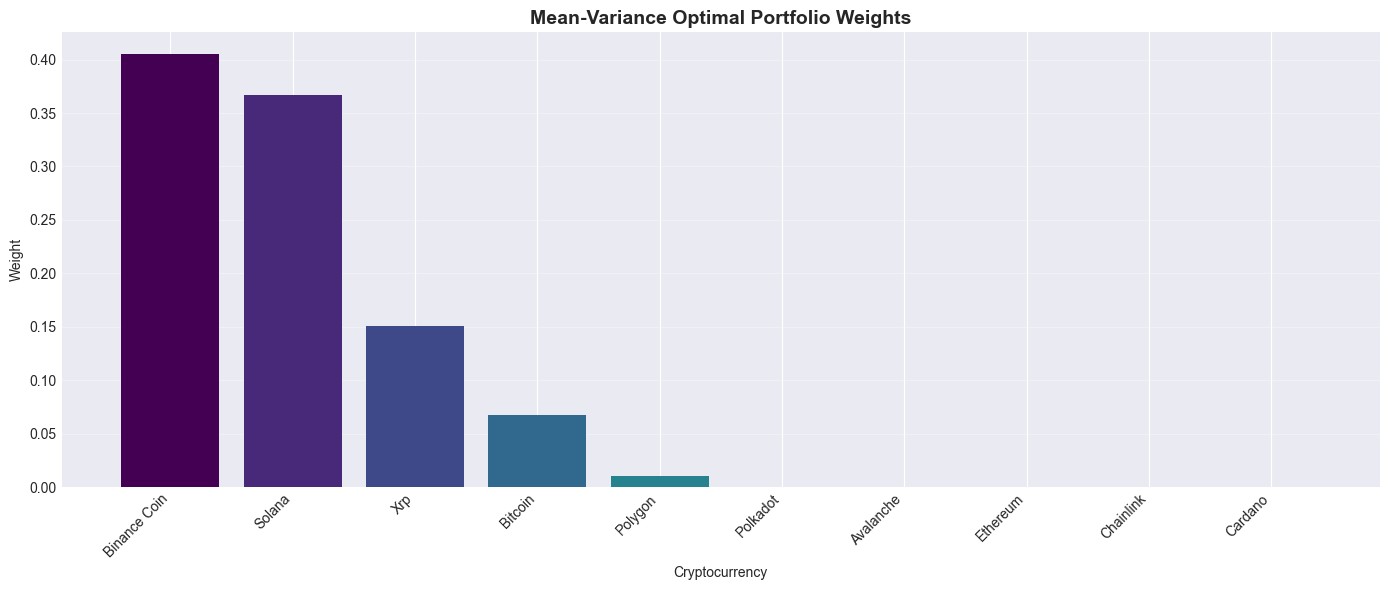

In [5]:
# Mean-Variance Optimization
def optimize_portfolio_mv(expected_returns, cov_matrix, target_return=None, risk_free_rate=0.0):
    """
    Optimize portfolio using Mean-Variance (Markowitz) approach.
    
    Parameters:
    - expected_returns: Expected returns vector
    - cov_matrix: Covariance matrix
    - target_return: Target return (if None, maximizes Sharpe ratio)
    - risk_free_rate: Risk-free rate
    
    Returns:
    - weights: Optimal portfolio weights
    - performance: (return, volatility, sharpe_ratio)
    """
    n_assets = len(expected_returns)
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds: weights between 0 and 1 (long-only portfolio)
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/n_assets] * n_assets)
    
    if target_return is None:
        # Maximize Sharpe ratio
        result = minimize(negative_sharpe, initial_weights,
                        args=(expected_returns, cov_matrix, risk_free_rate),
                        method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        # Minimize variance for target return
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return}
        ]
        result = minimize(portfolio_variance, initial_weights,
                        args=(cov_matrix,),
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        perf = portfolio_performance(weights, expected_returns, cov_matrix, risk_free_rate)
        return weights, perf
    else:
        raise ValueError("Optimization failed")

# Optimize portfolio
print("="*60)
print("MEAN-VARIANCE OPTIMIZATION (MARKOWITZ)")
print("="*60)

try:
    mv_weights, mv_performance = optimize_portfolio_mv(expected_returns, cov_matrix)
    
    print(f"\n✅ Optimal Portfolio Found:")
    print(f"   Expected Return: {mv_performance[0]:.4f} ({mv_performance[0]*100:.2f}% annualized)")
    print(f"   Volatility: {mv_performance[1]:.4f} ({mv_performance[1]*100:.2f}% annualized)")
    print(f"   Sharpe Ratio: {mv_performance[2]:.4f}")
    
    print(f"\n📊 Portfolio Weights:")
    mv_portfolio = pd.DataFrame({
        'Asset': expected_returns.index,
        'Weight': mv_weights,
        'Expected Return': expected_returns.values
    }).sort_values('Weight', ascending=False)
    print(mv_portfolio.to_string(index=False))
    
    # Visualize portfolio weights
    plt.figure(figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(mv_weights)))
    plt.bar(mv_portfolio['Asset'], mv_portfolio['Weight'], color=colors)
    plt.title('Mean-Variance Optimal Portfolio Weights', fontsize=14, fontweight='bold')
    plt.xlabel('Cryptocurrency')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    markowitz_result = {
        'weights': mv_weights,
        'performance': mv_performance,
        'portfolio_df': mv_portfolio
    }
    
except Exception as e:
    print(f"❌ Error in optimization: {str(e)}")
    markowitz_result = None


## 4. Risk Parity Portfolio


RISK PARITY OPTIMIZATION

✅ Risk Parity Portfolio Found:
   Expected Return: 0.6511 (65.11% annualized)
   Volatility: 0.6512 (65.12% annualized)
   Sharpe Ratio: 0.9998

📊 Portfolio Weights and Risk Contributions:
       Asset  Weight  Risk Contribution  Risk Contribution %
     Bitcoin  0.1551             0.0652              10.0166
Binance Coin  0.1167             0.0652              10.0073
    Ethereum  0.1130             0.0652              10.0088
         Xrp  0.0968             0.0650               9.9837
     Cardano  0.0925             0.0651               9.9907
    Polkadot  0.0916             0.0650               9.9870
   Chainlink  0.0894             0.0651               9.9985
      Solana  0.0858             0.0650               9.9776
   Avalanche  0.0808             0.0649               9.9718
     Polygon  0.0782             0.0655              10.0579


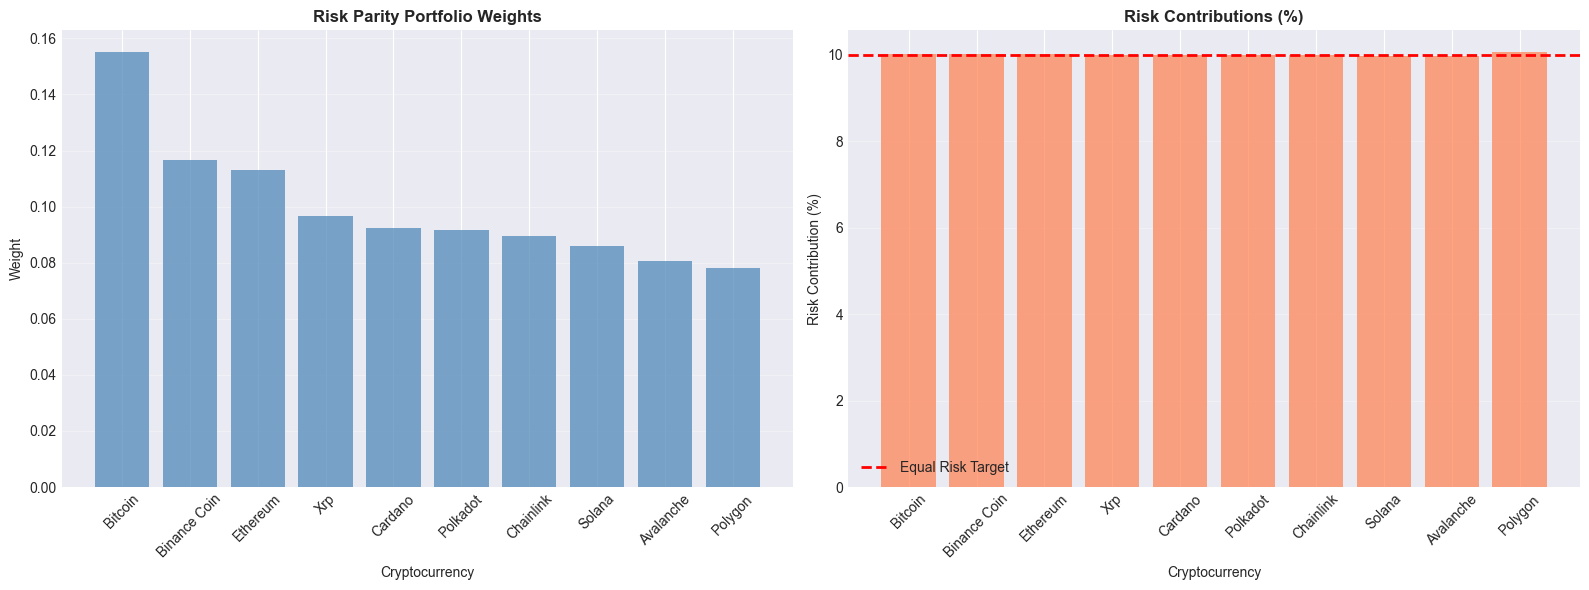

In [6]:
# Risk Parity Optimization
def optimize_risk_parity(cov_matrix):
    """
    Optimize portfolio using Risk Parity approach.
    Each asset contributes equally to portfolio risk.
    
    Parameters:
    - cov_matrix: Covariance matrix
    
    Returns:
    - weights: Optimal portfolio weights
    - performance: (return, volatility, sharpe_ratio)
    """
    n_assets = len(cov_matrix)
    
    def risk_parity_objective(weights, cov_matrix):
        """Minimize the difference in risk contributions."""
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol
        risk_contrib = weights * marginal_contrib
        
        # Target: equal risk contribution
        target_risk = portfolio_vol / n_assets
        
        # Minimize sum of squared differences from target
        return np.sum((risk_contrib - target_risk) ** 2)
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/n_assets] * n_assets)
    
    result = minimize(risk_parity_objective, initial_weights,
                     args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        perf = portfolio_performance(weights, expected_returns, cov_matrix)
        return weights, perf
    else:
        raise ValueError("Optimization failed")

# Optimize Risk Parity portfolio
print("="*60)
print("RISK PARITY OPTIMIZATION")
print("="*60)

try:
    rp_weights, rp_performance = optimize_risk_parity(cov_matrix)
    
    print(f"\n✅ Risk Parity Portfolio Found:")
    print(f"   Expected Return: {rp_performance[0]:.4f} ({rp_performance[0]*100:.2f}% annualized)")
    print(f"   Volatility: {rp_performance[1]:.4f} ({rp_performance[1]*100:.2f}% annualized)")
    print(f"   Sharpe Ratio: {rp_performance[2]:.4f}")
    
    # Calculate risk contributions
    portfolio_vol = rp_performance[1]
    marginal_contrib = np.dot(cov_matrix, rp_weights) / portfolio_vol
    risk_contrib = rp_weights * marginal_contrib
    
    print(f"\n📊 Portfolio Weights and Risk Contributions:")
    rp_portfolio = pd.DataFrame({
        'Asset': expected_returns.index,
        'Weight': rp_weights,
        'Risk Contribution': risk_contrib,
        'Risk Contribution %': (risk_contrib / portfolio_vol * 100)
    }).sort_values('Weight', ascending=False)
    print(rp_portfolio.to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Weights
    axes[0].bar(rp_portfolio['Asset'], rp_portfolio['Weight'], color='steelblue', alpha=0.7)
    axes[0].set_title('Risk Parity Portfolio Weights', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Cryptocurrency')
    axes[0].set_ylabel('Weight')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Risk Contributions
    axes[1].bar(rp_portfolio['Asset'], rp_portfolio['Risk Contribution %'], color='coral', alpha=0.7)
    axes[1].axhline(y=100/len(rp_weights), color='red', linestyle='--', linewidth=2, label='Equal Risk Target')
    axes[1].set_title('Risk Contributions (%)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Cryptocurrency')
    axes[1].set_ylabel('Risk Contribution (%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    risk_parity_result = {
        'weights': rp_weights,
        'performance': rp_performance,
        'portfolio_df': rp_portfolio
    }
    
except Exception as e:
    print(f"❌ Error in optimization: {str(e)}")
    risk_parity_result = None


## 5. Minimum Variance Portfolio


MINIMUM VARIANCE PORTFOLIO

✅ Minimum Variance Portfolio Found:
   Expected Return: 0.4800 (48.00% annualized)
   Volatility: 0.5072 (50.72% annualized)
   Sharpe Ratio: 0.9463

📊 Portfolio Weights:
       Asset  Weight  Expected Return
     Bitcoin  0.9142           0.4542
Binance Coin  0.0843           0.7548
         Xrp  0.0015           0.7811
   Chainlink  0.0000           0.4583
    Polkadot  0.0000           0.3718
     Cardano  0.0000           0.6859
    Ethereum  0.0000           0.4929
      Solana  0.0000           1.1011
     Polygon  0.0000           0.8906
   Avalanche  0.0000           0.7251


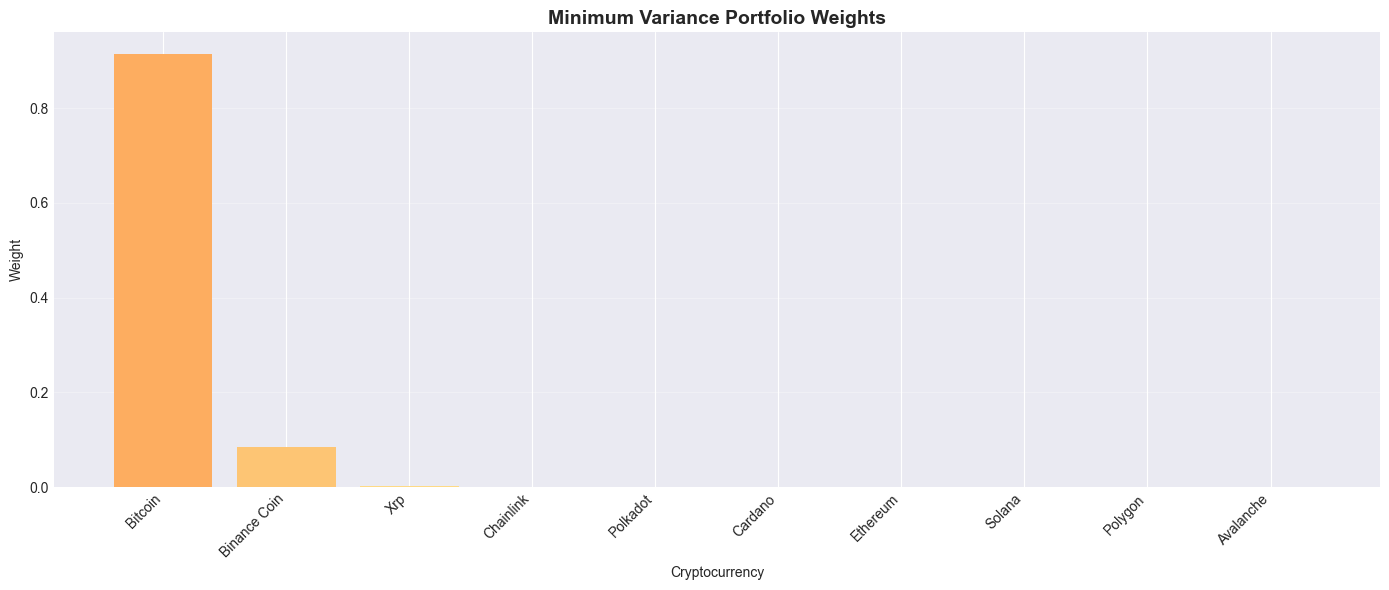

In [7]:
# Minimum Variance Portfolio
def optimize_min_variance(cov_matrix):
    """
    Optimize portfolio to minimize variance (lowest risk).
    
    Parameters:
    - cov_matrix: Covariance matrix
    
    Returns:
    - weights: Optimal portfolio weights
    - performance: (return, volatility, sharpe_ratio)
    """
    n_assets = len(cov_matrix)
    
    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Bounds: weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.array([1/n_assets] * n_assets)
    
    result = minimize(portfolio_variance, initial_weights,
                     args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        perf = portfolio_performance(weights, expected_returns, cov_matrix)
        return weights, perf
    else:
        raise ValueError("Optimization failed")

# Optimize Minimum Variance portfolio
print("="*60)
print("MINIMUM VARIANCE PORTFOLIO")
print("="*60)

try:
    minvar_weights, minvar_performance = optimize_min_variance(cov_matrix)
    
    print(f"\n✅ Minimum Variance Portfolio Found:")
    print(f"   Expected Return: {minvar_performance[0]:.4f} ({minvar_performance[0]*100:.2f}% annualized)")
    print(f"   Volatility: {minvar_performance[1]:.4f} ({minvar_performance[1]*100:.2f}% annualized)")
    print(f"   Sharpe Ratio: {minvar_performance[2]:.4f}")
    
    print(f"\n📊 Portfolio Weights:")
    minvar_portfolio = pd.DataFrame({
        'Asset': expected_returns.index,
        'Weight': minvar_weights,
        'Expected Return': expected_returns.values
    }).sort_values('Weight', ascending=False)
    print(minvar_portfolio.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(14, 6))
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.7, len(minvar_weights)))
    plt.bar(minvar_portfolio['Asset'], minvar_portfolio['Weight'], color=colors)
    plt.title('Minimum Variance Portfolio Weights', fontsize=14, fontweight='bold')
    plt.xlabel('Cryptocurrency')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    minvar_result = {
        'weights': minvar_weights,
        'performance': minvar_performance,
        'portfolio_df': minvar_portfolio
    }
    
except Exception as e:
    print(f"❌ Error in optimization: {str(e)}")
    minvar_result = None


## 6. Maximum Sharpe Ratio Portfolio


MAXIMUM SHARPE RATIO PORTFOLIO

✅ Maximum Sharpe Ratio Portfolio Found:
   Expected Return: 0.8668 (86.68% annualized)
   Volatility: 0.7015 (70.15% annualized)
   Sharpe Ratio: 1.2357

📊 Portfolio Weights:
       Asset  Weight  Expected Return
Binance Coin  0.4052           0.7548
      Solana  0.3667           1.1011
         Xrp  0.1505           0.7811
     Bitcoin  0.0675           0.4542
     Polygon  0.0100           0.8906
    Polkadot  0.0000           0.3718
   Avalanche  0.0000           0.7251
    Ethereum  0.0000           0.4929
   Chainlink  0.0000           0.4583
     Cardano  0.0000           0.6859


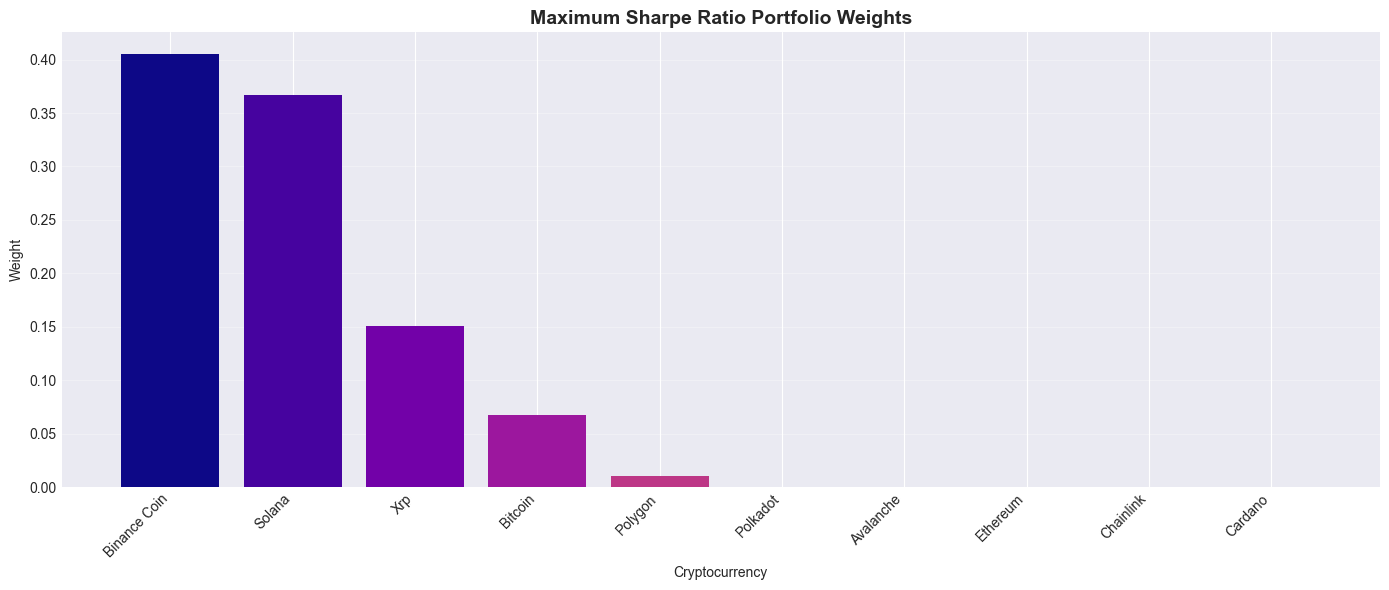

In [8]:
# Maximum Sharpe Ratio Portfolio (already computed in Mean-Variance, but shown separately)
print("="*60)
print("MAXIMUM SHARPE RATIO PORTFOLIO")
print("="*60)

if markowitz_result is not None:
    maxsharpe_weights = markowitz_result['weights']
    maxsharpe_performance = markowitz_result['performance']
    
    print(f"\n✅ Maximum Sharpe Ratio Portfolio Found:")
    print(f"   Expected Return: {maxsharpe_performance[0]:.4f} ({maxsharpe_performance[0]*100:.2f}% annualized)")
    print(f"   Volatility: {maxsharpe_performance[1]:.4f} ({maxsharpe_performance[1]*100:.2f}% annualized)")
    print(f"   Sharpe Ratio: {maxsharpe_performance[2]:.4f}")
    
    print(f"\n📊 Portfolio Weights:")
    maxsharpe_portfolio = pd.DataFrame({
        'Asset': expected_returns.index,
        'Weight': maxsharpe_weights,
        'Expected Return': expected_returns.values
    }).sort_values('Weight', ascending=False)
    print(maxsharpe_portfolio.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(14, 6))
    colors = plt.cm.plasma(np.linspace(0, 1, len(maxsharpe_weights)))
    plt.bar(maxsharpe_portfolio['Asset'], maxsharpe_portfolio['Weight'], color=colors)
    plt.title('Maximum Sharpe Ratio Portfolio Weights', fontsize=14, fontweight='bold')
    plt.xlabel('Cryptocurrency')
    plt.ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    maxsharpe_result = {
        'weights': maxsharpe_weights,
        'performance': maxsharpe_performance,
        'portfolio_df': maxsharpe_portfolio
    }
else:
    print("⚠️ Maximum Sharpe Ratio portfolio not available (Mean-Variance optimization failed)")
    maxsharpe_result = None


## 7. Efficient Frontier


EFFICIENT FRONTIER GENERATION
✅ Generated 50 efficient portfolios


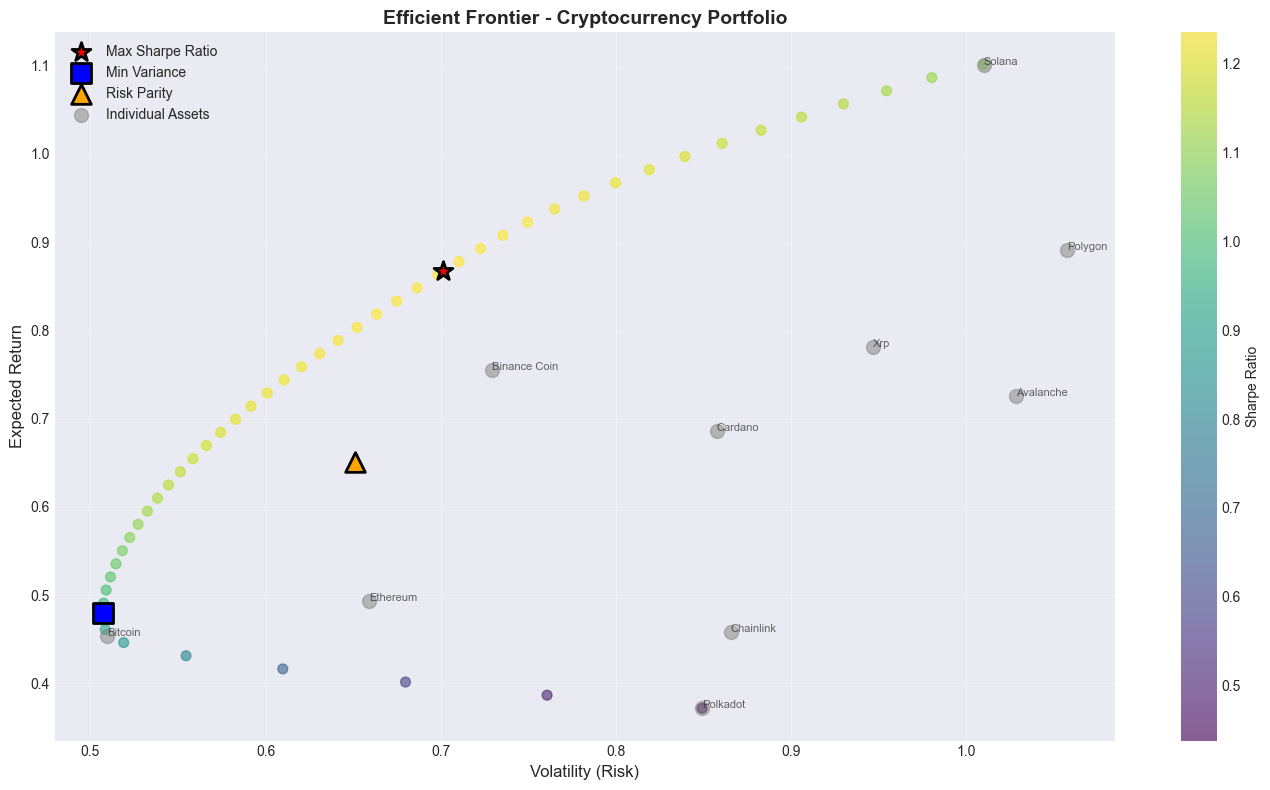


✅ Efficient frontier generated and visualized


In [9]:
# Generate Efficient Frontier
print("="*60)
print("EFFICIENT FRONTIER GENERATION")
print("="*60)

def generate_efficient_frontier(expected_returns, cov_matrix, num_portfolios=100):
    """
    Generate efficient frontier portfolios.
    
    Parameters:
    - expected_returns: Expected returns vector
    - cov_matrix: Covariance matrix
    - num_portfolios: Number of portfolios to generate
    
    Returns:
    - results: DataFrame with portfolio returns, volatilities, and Sharpe ratios
    """
    min_return = expected_returns.min()
    max_return = expected_returns.max()
    target_returns = np.linspace(min_return, max_return, num_portfolios)
    
    efficient_portfolios = []
    
    for target_ret in target_returns:
        try:
            weights, perf = optimize_portfolio_mv(expected_returns, cov_matrix, target_return=target_ret)
            efficient_portfolios.append({
                'Return': perf[0],
                'Volatility': perf[1],
                'Sharpe': perf[2],
                'Weights': weights
            })
        except:
            continue
    
    return pd.DataFrame(efficient_portfolios)

# Generate efficient frontier
try:
    efficient_frontier = generate_efficient_frontier(expected_returns, cov_matrix, num_portfolios=50)
    
    print(f"✅ Generated {len(efficient_frontier)} efficient portfolios")
    
    # Plot efficient frontier
    plt.figure(figsize=(14, 8))
    
    # Efficient frontier
    plt.scatter(efficient_frontier['Volatility'], efficient_frontier['Return'], 
               c=efficient_frontier['Sharpe'], cmap='viridis', alpha=0.6, s=50)
    plt.colorbar(label='Sharpe Ratio')
    
    # Mark optimal portfolios
    if markowitz_result:
        mv_perf = markowitz_result['performance']
        plt.scatter(mv_perf[1], mv_perf[0], color='red', s=200, marker='*', 
                   label='Max Sharpe Ratio', zorder=5, edgecolors='black', linewidths=2)
    
    if minvar_result:
        minvar_perf = minvar_result['performance']
        plt.scatter(minvar_perf[1], minvar_perf[0], color='blue', s=200, marker='s', 
                   label='Min Variance', zorder=5, edgecolors='black', linewidths=2)
    
    if risk_parity_result:
        rp_perf = risk_parity_result['performance']
        plt.scatter(rp_perf[1], rp_perf[0], color='orange', s=200, marker='^', 
                   label='Risk Parity', zorder=5, edgecolors='black', linewidths=2)
    
    # Individual assets
    individual_vol = np.sqrt(np.diag(cov_matrix))
    plt.scatter(individual_vol, expected_returns, color='gray', s=100, 
               marker='o', alpha=0.5, label='Individual Assets', zorder=3)
    
    # Add asset labels
    for i, asset in enumerate(expected_returns.index):
        plt.annotate(asset, (individual_vol[i], expected_returns[i]), 
                    fontsize=8, alpha=0.7)
    
    plt.xlabel('Volatility (Risk)', fontsize=12)
    plt.ylabel('Expected Return', fontsize=12)
    plt.title('Efficient Frontier - Cryptocurrency Portfolio', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Efficient frontier generated and visualized")
    
except Exception as e:
    print(f"❌ Error generating efficient frontier: {str(e)}")
    efficient_frontier = None


## 8. Portfolio Comparison


PORTFOLIO STRATEGY COMPARISON

📊 Portfolio Strategy Comparison:
        Strategy  Expected Return  Volatility  Sharpe Ratio
Max Sharpe Ratio           0.8668      0.7015        1.2357
     Risk Parity           0.6511      0.6512        0.9998
    Min Variance           0.4800      0.5072        0.9463


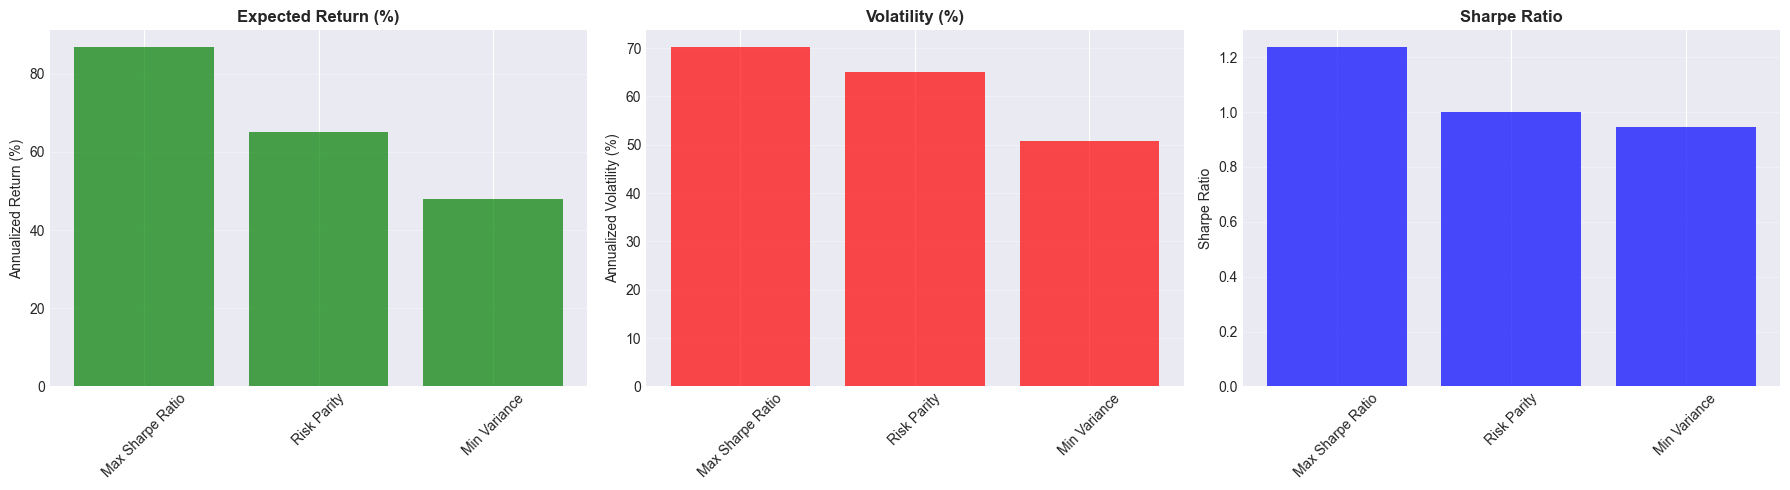

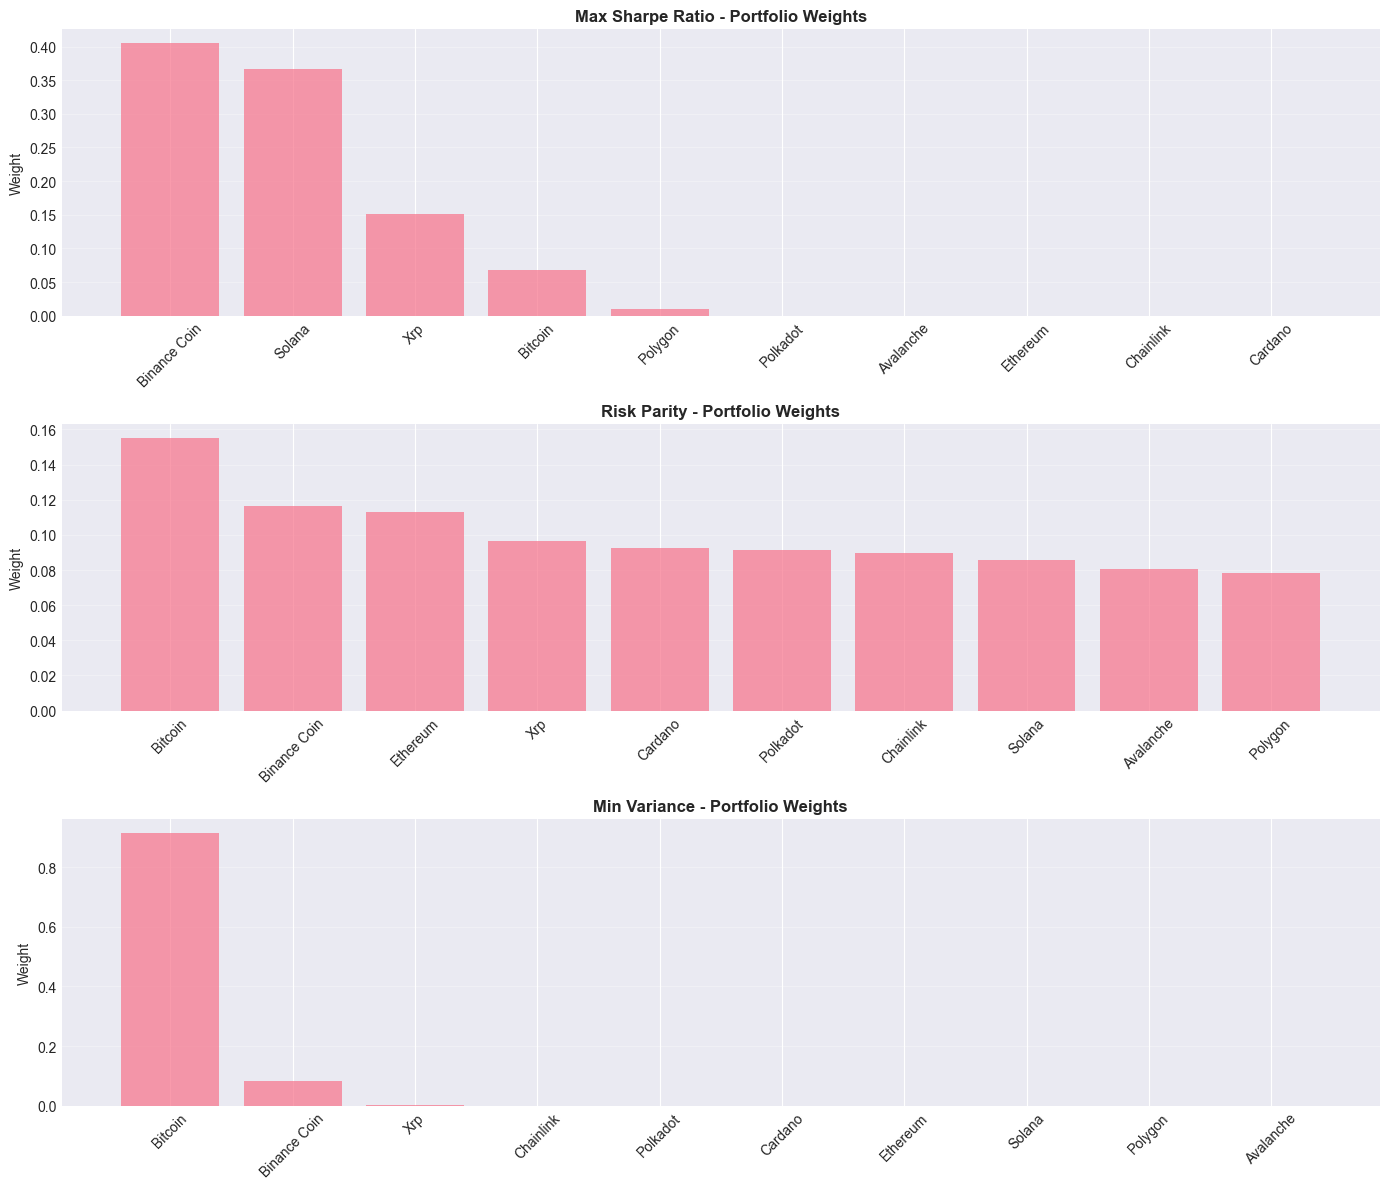


✅ Portfolio comparison completed


In [10]:
# Compare all portfolio strategies
print("="*60)
print("PORTFOLIO STRATEGY COMPARISON")
print("="*60)

comparison_data = []

strategies = {
    'Max Sharpe Ratio': maxsharpe_result,
    'Risk Parity': risk_parity_result,
    'Min Variance': minvar_result
}

for strategy_name, result in strategies.items():
    if result is not None:
        perf = result['performance']
        comparison_data.append({
            'Strategy': strategy_name,
            'Expected Return': perf[0],
            'Volatility': perf[1],
            'Sharpe Ratio': perf[2]
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n📊 Portfolio Strategy Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Returns
    axes[0].bar(comparison_df['Strategy'], comparison_df['Expected Return'] * 100, 
               color='green', alpha=0.7)
    axes[0].set_title('Expected Return (%)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Annualized Return (%)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Volatility
    axes[1].bar(comparison_df['Strategy'], comparison_df['Volatility'] * 100, 
               color='red', alpha=0.7)
    axes[1].set_title('Volatility (%)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Annualized Volatility (%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Sharpe Ratio
    axes[2].bar(comparison_df['Strategy'], comparison_df['Sharpe Ratio'], 
               color='blue', alpha=0.7)
    axes[2].set_title('Sharpe Ratio', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Sharpe Ratio')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Compare weights
    fig, axes = plt.subplots(len(comparison_data), 1, figsize=(14, 4*len(comparison_data)))
    if len(comparison_data) == 1:
        axes = [axes]
    
    for idx, (strategy_name, result) in enumerate(strategies.items()):
        if result is not None:
            weights_df = result['portfolio_df'].sort_values('Weight', ascending=False)
            axes[idx].bar(weights_df['Asset'], weights_df['Weight'], alpha=0.7)
            axes[idx].set_title(f'{strategy_name} - Portfolio Weights', fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Weight')
            axes[idx].tick_params(axis='x', rotation=45)
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Portfolio comparison completed")
else:
    print("⚠️ No portfolio results available for comparison")


## 9. Portfolio Backtesting


PORTFOLIO BACKTESTING

📊 Backtesting Max Sharpe Ratio...
   Total Return: 29874.11%
   Annualized Return: 139.69%
   Volatility: 72.49%
   Sharpe Ratio: 1.9270
   Max Drawdown: -77.72%

📊 Backtesting Risk Parity...
   Total Return: 10010.86%
   Annualized Return: 102.91%
   Volatility: 66.98%
   Sharpe Ratio: 1.5364
   Max Drawdown: -74.09%

📊 Backtesting Min Variance...
   Total Return: 1142.10%
   Annualized Return: 47.14%
   Volatility: 51.08%
   Sharpe Ratio: 0.9227
   Max Drawdown: -75.15%


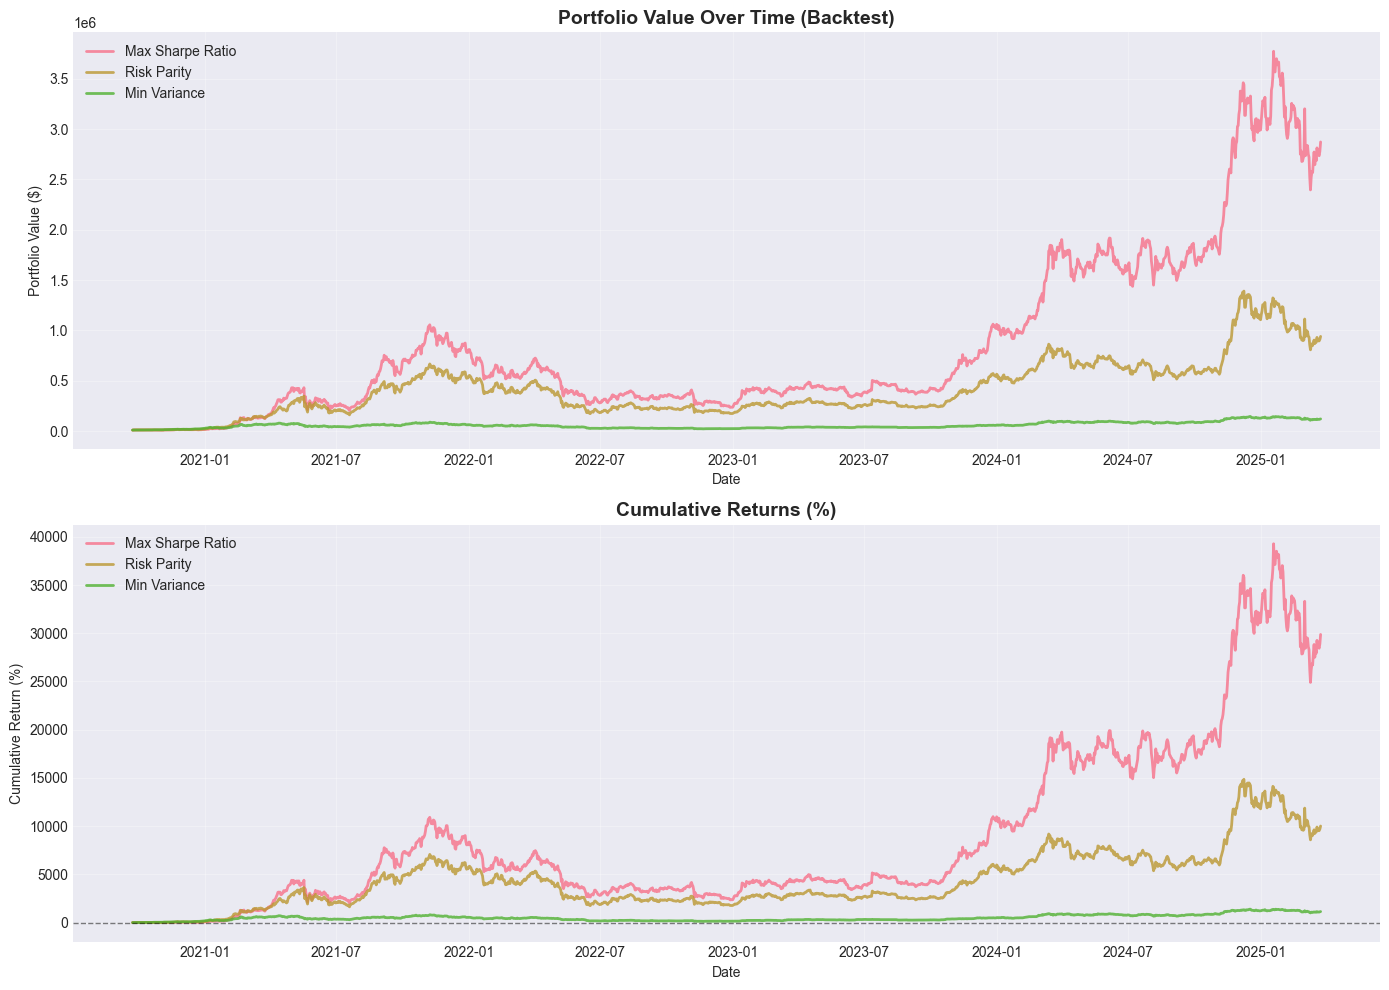


📊 Backtest Performance Summary:
        Strategy  Total Return (%)  Annualized Return (%)  Volatility (%)  Sharpe Ratio  Max Drawdown (%)
Max Sharpe Ratio        29874.1063               139.6885         72.4897        1.9270          -77.7238
     Risk Parity        10010.8557               102.9099         66.9830        1.5364          -74.0887
    Min Variance         1142.1038                47.1356         51.0835        0.9227          -75.1492

✅ Backtesting completed


In [11]:
# Portfolio Backtesting
def backtest_portfolio(weights, returns_df, initial_value=10000, rebalance_freq='M'):
    """
    Backtest a portfolio strategy.
    
    Parameters:
    - weights: Portfolio weights
    - returns_df: DataFrame of asset returns
    - initial_value: Initial portfolio value
    - rebalance_freq: Rebalancing frequency ('D', 'W', 'M', 'Q', 'Y')
    
    Returns:
    - portfolio_value: Series of portfolio values over time
    - portfolio_returns: Series of portfolio returns
    """
    portfolio_value = [initial_value]
    portfolio_returns = []
    
    # Get rebalancing dates
    if rebalance_freq == 'D':
        rebalance_dates = returns_df.index
    elif rebalance_freq == 'W':
        rebalance_dates = returns_df.resample('W').last().index
    elif rebalance_freq == 'M':
        rebalance_dates = returns_df.resample('M').last().index
    elif rebalance_freq == 'Q':
        rebalance_dates = returns_df.resample('Q').last().index
    else:
        rebalance_dates = returns_df.resample('Y').last().index
    
    current_value = initial_value
    last_rebalance = returns_df.index[0]
    
    for date in returns_df.index:
        # Check if rebalancing is needed
        if date in rebalance_dates or date == returns_df.index[0]:
            # Rebalance to target weights
            current_weights = weights
            last_rebalance = date
        else:
            # Calculate current weights based on returns
            period_returns = returns_df.loc[last_rebalance:date].sum()
            current_weights = weights * (1 + period_returns)
            current_weights = current_weights / current_weights.sum()
        
        # Calculate portfolio return for this period
        period_return = np.dot(current_weights, returns_df.loc[date])
        portfolio_returns.append(period_return)
        
        # Update portfolio value
        current_value = current_value * (1 + period_return)
        portfolio_value.append(current_value)
    
    portfolio_value_series = pd.Series(portfolio_value[1:], index=returns_df.index)
    portfolio_returns_series = pd.Series(portfolio_returns, index=returns_df.index)
    
    return portfolio_value_series, portfolio_returns_series

print("="*60)
print("PORTFOLIO BACKTESTING")
print("="*60)

# Backtest different strategies
backtest_results = {}

for strategy_name, result in strategies.items():
    if result is not None:
        print(f"\n📊 Backtesting {strategy_name}...")
        try:
            portfolio_value, portfolio_returns = backtest_portfolio(
                result['weights'], returns_df, initial_value=10000, rebalance_freq='M'
            )
            
            # Calculate performance metrics
            total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1) * 100
            annualized_return = ((portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1) * 100
            volatility = portfolio_returns.std() * np.sqrt(252) * 100
            sharpe_ratio = (annualized_return / 100) / (volatility / 100) if volatility > 0 else 0
            max_drawdown = ((portfolio_value / portfolio_value.expanding().max()) - 1).min() * 100
            
            backtest_results[strategy_name] = {
                'portfolio_value': portfolio_value,
                'portfolio_returns': portfolio_returns,
                'total_return': total_return,
                'annualized_return': annualized_return,
                'volatility': volatility,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown
            }
            
            print(f"   Total Return: {total_return:.2f}%")
            print(f"   Annualized Return: {annualized_return:.2f}%")
            print(f"   Volatility: {volatility:.2f}%")
            print(f"   Sharpe Ratio: {sharpe_ratio:.4f}")
            print(f"   Max Drawdown: {max_drawdown:.2f}%")
            
        except Exception as e:
            print(f"   ❌ Error in backtesting: {str(e)}")
            continue

# Visualize backtest results
if backtest_results:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Portfolio value over time
    for strategy_name, result in backtest_results.items():
        axes[0].plot(result['portfolio_value'].index, result['portfolio_value'].values, 
                     label=strategy_name, linewidth=2, alpha=0.8)
    axes[0].set_title('Portfolio Value Over Time (Backtest)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative returns
    for strategy_name, result in backtest_results.items():
        cumulative_returns = (result['portfolio_value'] / result['portfolio_value'].iloc[0] - 1) * 100
        axes[1].plot(cumulative_returns.index, cumulative_returns.values, 
                     label=strategy_name, linewidth=2, alpha=0.8)
    axes[1].set_title('Cumulative Returns (%)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Cumulative Return (%)')
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Backtest performance summary
    backtest_summary = pd.DataFrame({
        'Strategy': list(backtest_results.keys()),
        'Total Return (%)': [r['total_return'] for r in backtest_results.values()],
        'Annualized Return (%)': [r['annualized_return'] for r in backtest_results.values()],
        'Volatility (%)': [r['volatility'] for r in backtest_results.values()],
        'Sharpe Ratio': [r['sharpe_ratio'] for r in backtest_results.values()],
        'Max Drawdown (%)': [r['max_drawdown'] for r in backtest_results.values()]
    })
    
    print("\n📊 Backtest Performance Summary:")
    print(backtest_summary.to_string(index=False))
    
    print("\n✅ Backtesting completed")
else:
    print("⚠️ No backtest results available")


REBALANCING STRATEGY COMPARISON

📊 Testing Monthly Rebalancing...
   Total Return: 29874.11%
   Annualized Return: 139.69%
   Volatility: 72.49%
   Sharpe Ratio: 1.9270

📊 Testing Quarterly Rebalancing...
   Total Return: 21875.14%
   Annualized Return: 128.55%
   Volatility: 72.26%
   Sharpe Ratio: 1.7791


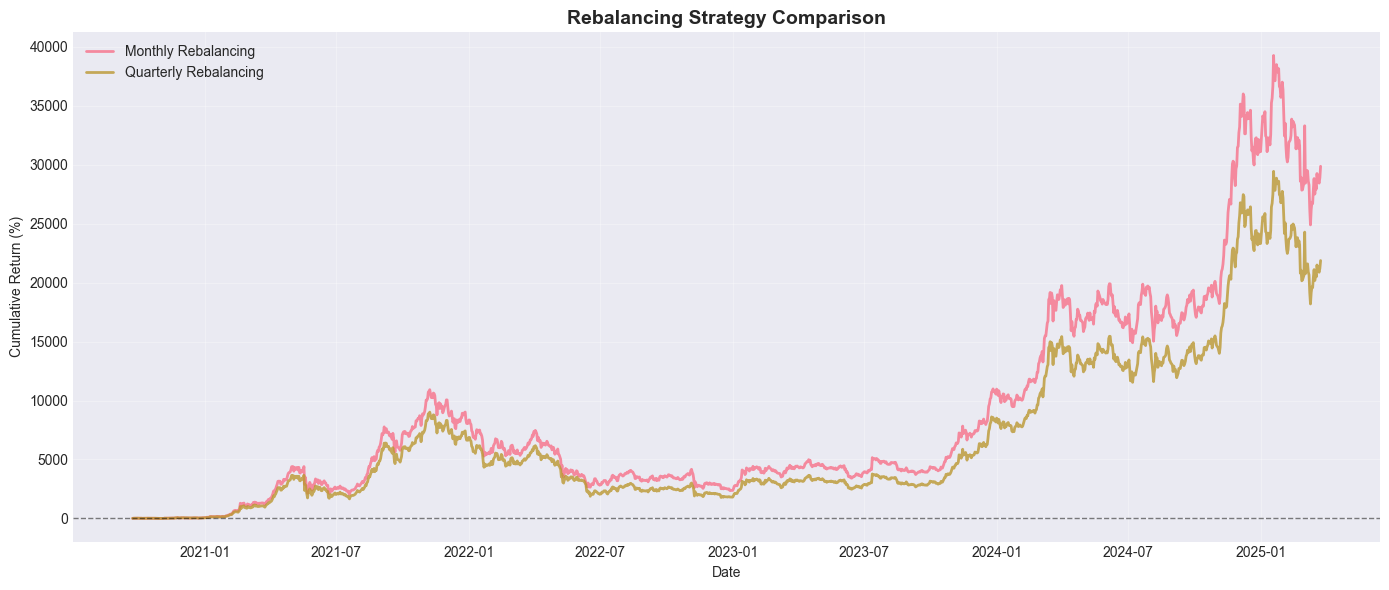


📊 Rebalancing Strategy Comparison:
Rebalancing Frequency  Total Return (%)  Annualized Return (%)  Volatility (%)  Sharpe Ratio
              Monthly        29874.1063               139.6885         72.4897        1.9270
            Quarterly        21875.1440               128.5505         72.2566        1.7791

✅ Rebalancing analysis completed


In [12]:
# Compare different rebalancing frequencies
print("="*60)
print("REBALANCING STRATEGY COMPARISON")
print("="*60)

if markowitz_result is not None:
    rebalance_frequencies = ['M', 'Q']  # Monthly and Quarterly
    rebalance_results = {}
    
    for freq in rebalance_frequencies:
        freq_name = {'M': 'Monthly', 'Q': 'Quarterly'}[freq]
        print(f"\n📊 Testing {freq_name} Rebalancing...")
        
        try:
            portfolio_value, portfolio_returns = backtest_portfolio(
                markowitz_result['weights'], returns_df, initial_value=10000, rebalance_freq=freq
            )
            
            total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1) * 100
            annualized_return = ((portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1) * 100
            volatility = portfolio_returns.std() * np.sqrt(252) * 100
            sharpe_ratio = (annualized_return / 100) / (volatility / 100) if volatility > 0 else 0
            
            rebalance_results[freq_name] = {
                'portfolio_value': portfolio_value,
                'total_return': total_return,
                'annualized_return': annualized_return,
                'volatility': volatility,
                'sharpe_ratio': sharpe_ratio
            }
            
            print(f"   Total Return: {total_return:.2f}%")
            print(f"   Annualized Return: {annualized_return:.2f}%")
            print(f"   Volatility: {volatility:.2f}%")
            print(f"   Sharpe Ratio: {sharpe_ratio:.4f}")
            
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            continue
    
    # Visualize rebalancing comparison
    if rebalance_results:
        plt.figure(figsize=(14, 6))
        for freq_name, result in rebalance_results.items():
            cumulative_returns = (result['portfolio_value'] / result['portfolio_value'].iloc[0] - 1) * 100
            plt.plot(cumulative_returns.index, cumulative_returns.values, 
                    label=f'{freq_name} Rebalancing', linewidth=2, alpha=0.8)
        
        plt.title('Rebalancing Strategy Comparison', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # Summary table
        rebalance_summary = pd.DataFrame({
            'Rebalancing Frequency': list(rebalance_results.keys()),
            'Total Return (%)': [r['total_return'] for r in rebalance_results.values()],
            'Annualized Return (%)': [r['annualized_return'] for r in rebalance_results.values()],
            'Volatility (%)': [r['volatility'] for r in rebalance_results.values()],
            'Sharpe Ratio': [r['sharpe_ratio'] for r in rebalance_results.values()]
        })
        
        print("\n📊 Rebalancing Strategy Comparison:")
        print(rebalance_summary.to_string(index=False))
        
        print("\n✅ Rebalancing analysis completed")
    else:
        print("⚠️ No rebalancing results available")
else:
    print("⚠️ Rebalancing analysis requires Mean-Variance optimization results")


## 11. Transaction Costs Analysis


TRANSACTION COSTS ANALYSIS

📊 Testing with 0.00% transaction costs...
   Total Return: 71698.13%
   Annualized Return: 174.03%
   Total Transaction Costs: $0.00 (0.00% of initial)

📊 Testing with 0.10% transaction costs...
   Total Return: 67586.94%
   Annualized Return: 171.56%
   Total Transaction Costs: $83106.55 (831.07% of initial)

📊 Testing with 0.20% transaction costs...
   Total Return: 63706.32%
   Annualized Return: 169.12%
   Total Transaction Costs: $158654.94 (1586.55% of initial)

📊 Testing with 0.50% transaction costs...
   Total Return: 53324.72%
   Annualized Return: 161.89%
   Total Transaction Costs: $345188.56 (3451.89% of initial)


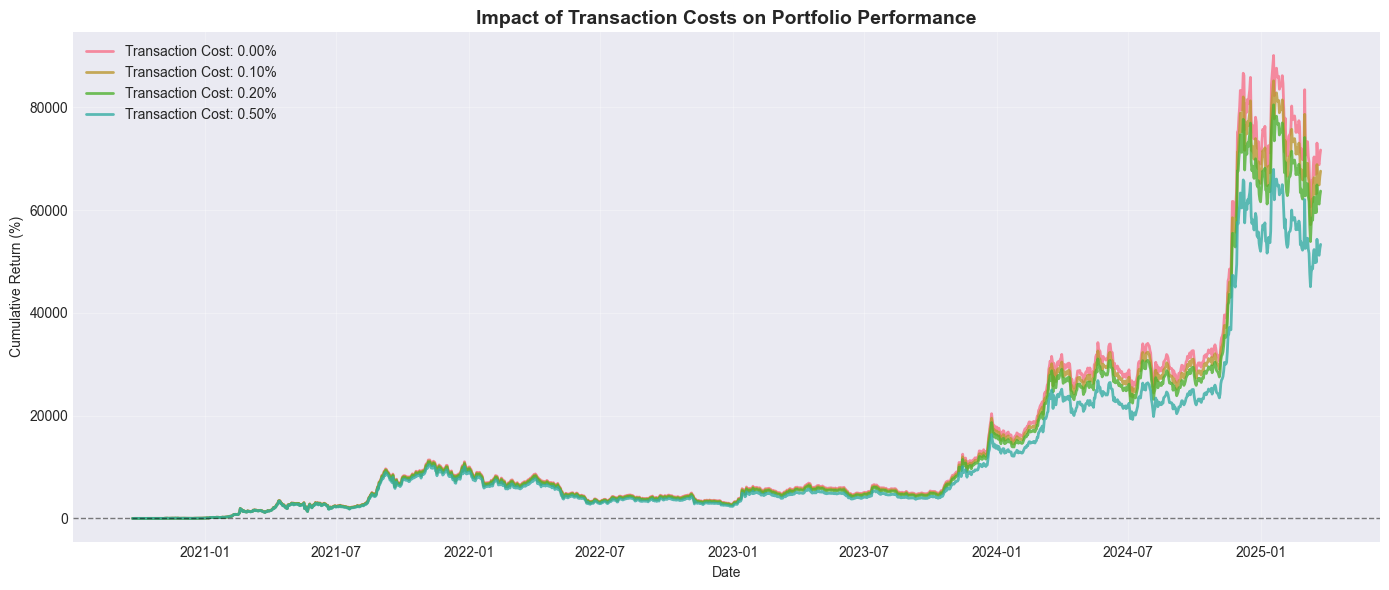


📊 Transaction Costs Impact Summary:
Transaction Cost  Total Return (%)  Annualized Return (%)  Total Costs ($)  Costs as % of Initial
           0.00%        71698.1335               174.0302           0.0000                 0.0000
           0.10%        67586.9361               171.5645       83106.5466               831.0655
           0.20%        63706.3217               169.1179      158654.9402              1586.5494
           0.50%        53324.7195               161.8913      345188.5561              3451.8856

✅ Transaction costs analysis completed


In [13]:
# Transaction Costs Analysis
def backtest_with_costs(weights, returns_df, initial_value=10000, rebalance_freq='M', transaction_cost=0.001):
    """
    Backtest portfolio with transaction costs.
    
    Parameters:
    - weights: Portfolio weights
    - returns_df: DataFrame of asset returns
    - initial_value: Initial portfolio value
    - rebalance_freq: Rebalancing frequency
    - transaction_cost: Transaction cost as fraction (e.g., 0.001 = 0.1%)
    
    Returns:
    - portfolio_value: Series of portfolio values over time
    - total_costs: Total transaction costs incurred
    """
    portfolio_value = [initial_value]
    total_costs = 0
    
    # Get rebalancing dates
    if rebalance_freq == 'M':
        rebalance_dates = returns_df.resample('M').last().index
    elif rebalance_freq == 'Q':
        rebalance_dates = returns_df.resample('Q').last().index
    else:
        rebalance_dates = returns_df.resample('M').last().index
    
    current_value = initial_value
    current_weights = weights.copy()
    last_rebalance = returns_df.index[0]
    
    for date in returns_df.index:
        # Calculate current weights based on returns
        if date > last_rebalance:
            period_returns = returns_df.loc[last_rebalance:date].sum()
            current_weights = current_weights * (1 + period_returns)
            current_weights = current_weights / current_weights.sum()
        
        # Check if rebalancing is needed
        if date in rebalance_dates or date == returns_df.index[0]:
            # Calculate transaction costs
            weight_change = np.abs(weights - current_weights)
            cost = current_value * np.sum(weight_change) * transaction_cost
            total_costs += cost
            current_value -= cost
            current_weights = weights.copy()
            last_rebalance = date
        
        # Calculate portfolio return for this period
        period_return = np.dot(current_weights, returns_df.loc[date])
        
        # Update portfolio value
        current_value = current_value * (1 + period_return)
        portfolio_value.append(current_value)
    
    portfolio_value_series = pd.Series(portfolio_value[1:], index=returns_df.index)
    
    return portfolio_value_series, total_costs

print("="*60)
print("TRANSACTION COSTS ANALYSIS")
print("="*60)

if markowitz_result is not None:
    transaction_costs = [0.0, 0.001, 0.002, 0.005]  # 0%, 0.1%, 0.2%, 0.5%
    cost_results = {}
    
    for cost_rate in transaction_costs:
        cost_pct = cost_rate * 100
        print(f"\n📊 Testing with {cost_pct:.2f}% transaction costs...")
        
        try:
            portfolio_value, total_costs = backtest_with_costs(
                markowitz_result['weights'], returns_df, 
                initial_value=10000, rebalance_freq='M', transaction_cost=cost_rate
            )
            
            total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0] - 1) * 100
            annualized_return = ((portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252 / len(portfolio_value)) - 1) * 100
            
            cost_results[f'{cost_pct:.2f}%'] = {
                'portfolio_value': portfolio_value,
                'total_return': total_return,
                'annualized_return': annualized_return,
                'total_costs': total_costs,
                'cost_pct_of_initial': (total_costs / 10000) * 100
            }
            
            print(f"   Total Return: {total_return:.2f}%")
            print(f"   Annualized Return: {annualized_return:.2f}%")
            print(f"   Total Transaction Costs: ${total_costs:.2f} ({total_costs/10000*100:.2f}% of initial)")
            
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
            continue
    
    # Visualize impact of transaction costs
    if cost_results:
        plt.figure(figsize=(14, 6))
        for cost_label, result in cost_results.items():
            cumulative_returns = (result['portfolio_value'] / result['portfolio_value'].iloc[0] - 1) * 100
            plt.plot(cumulative_returns.index, cumulative_returns.values, 
                    label=f'Transaction Cost: {cost_label}', linewidth=2, alpha=0.8)
        
        plt.title('Impact of Transaction Costs on Portfolio Performance', fontsize=14, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # Summary table
        cost_summary = pd.DataFrame({
            'Transaction Cost': list(cost_results.keys()),
            'Total Return (%)': [r['total_return'] for r in cost_results.values()],
            'Annualized Return (%)': [r['annualized_return'] for r in cost_results.values()],
            'Total Costs ($)': [r['total_costs'] for r in cost_results.values()],
            'Costs as % of Initial': [r['cost_pct_of_initial'] for r in cost_results.values()]
        })
        
        print("\n📊 Transaction Costs Impact Summary:")
        print(cost_summary.to_string(index=False))
        
        print("\n✅ Transaction costs analysis completed")
    else:
        print("⚠️ No transaction cost results available")
else:
    print("⚠️ Transaction costs analysis requires Mean-Variance optimization results")


## 12. Summary and Key Insights


In [14]:
# Generate summary
print("="*80)
print("PORTFOLIO OPTIMIZATION SUMMARY")
print("="*80)

print(f"\n📊 Optimization Strategies Implemented:")
strategies_implemented = []
if markowitz_result:
    strategies_implemented.append("✅ Mean-Variance (Max Sharpe Ratio)")
if risk_parity_result:
    strategies_implemented.append("✅ Risk Parity")
if minvar_result:
    strategies_implemented.append("✅ Minimum Variance")

for strategy in strategies_implemented:
    print(f"   {strategy}")

print(f"\n📈 Portfolio Statistics:")
print(f"   Number of Assets: {len(expected_returns)}")
print(f"   Date Range: {returns_df.index.min().date()} to {returns_df.index.max().date()}")
print(f"   Total Trading Days: {len(returns_df)}")

if comparison_data:
    print(f"\n🏆 Best Strategy by Metric:")
    comp_df = pd.DataFrame(comparison_data)
    best_return = comp_df.loc[comp_df['Expected Return'].idxmax(), 'Strategy']
    best_sharpe = comp_df.loc[comp_df['Sharpe Ratio'].idxmax(), 'Strategy']
    lowest_vol = comp_df.loc[comp_df['Volatility'].idxmin(), 'Strategy']
    print(f"   Highest Return: {best_return}")
    print(f"   Highest Sharpe Ratio: {best_sharpe}")
    print(f"   Lowest Volatility: {lowest_vol}")

if backtest_results:
    print(f"\n📊 Backtest Results:")
    for strategy, result in backtest_results.items():
        print(f"   {strategy}:")
        print(f"      Total Return: {result['total_return']:.2f}%")
        print(f"      Sharpe Ratio: {result['sharpe_ratio']:.4f}")
        print(f"      Max Drawdown: {result['max_drawdown']:.2f}%")

print(f"\n💡 Key Insights:")
print("   1. Different optimization strategies suit different risk preferences")
print("   2. Mean-Variance optimization maximizes risk-adjusted returns (Sharpe ratio)")
print("   3. Risk Parity provides balanced risk contribution across assets")
print("   4. Minimum Variance minimizes portfolio risk but may sacrifice returns")
print("   5. Rebalancing frequency affects performance and transaction costs")
print("   6. Transaction costs can significantly impact portfolio returns")
print("   7. Efficient frontier shows the trade-off between risk and return")

print(f"\n⚠️  Important Notes:")
print("   - Past performance does not guarantee future results")
print("   - Portfolio optimization assumes historical patterns will continue")
print("   - Transaction costs and liquidity should be considered in real trading")
print("   - Regular rebalancing is important to maintain target allocations")
print("   - Diversification helps reduce portfolio risk")

print("\n" + "="*80)
print("Portfolio Optimization Analysis Complete!")
print("="*80)


PORTFOLIO OPTIMIZATION SUMMARY

📊 Optimization Strategies Implemented:
   ✅ Mean-Variance (Max Sharpe Ratio)
   ✅ Risk Parity
   ✅ Minimum Variance

📈 Portfolio Statistics:
   Number of Assets: 10
   Date Range: 2020-09-23 to 2025-03-24
   Total Trading Days: 1644

🏆 Best Strategy by Metric:
   Highest Return: Max Sharpe Ratio
   Highest Sharpe Ratio: Max Sharpe Ratio
   Lowest Volatility: Min Variance

📊 Backtest Results:
   Max Sharpe Ratio:
      Total Return: 29874.11%
      Sharpe Ratio: 1.9270
      Max Drawdown: -77.72%
   Risk Parity:
      Total Return: 10010.86%
      Sharpe Ratio: 1.5364
      Max Drawdown: -74.09%
   Min Variance:
      Total Return: 1142.10%
      Sharpe Ratio: 0.9227
      Max Drawdown: -75.15%

💡 Key Insights:
   1. Different optimization strategies suit different risk preferences
   2. Mean-Variance optimization maximizes risk-adjusted returns (Sharpe ratio)
   3. Risk Parity provides balanced risk contribution across assets
   4. Minimum Variance minim